In [35]:
# Imports
import numpy.typing as npt
import numpy as np
import pandas as df
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [36]:
# Read Data
set1: npt.NDArray[np.float16] = df.read_csv("set1.csv").to_numpy()
set2: npt.NDArray[np.float16] = df.read_csv("set2.csv").to_numpy()
set3: npt.NDArray[np.float16] = df.read_csv("set3.csv").to_numpy()

# Data from Simulations [FIX]
s12p1_th: float = 58.834546574932
s12p2_th: float = 38.901878581189
s3p1_th: float = 43.099727130196
s3p2_th: float = 28.497887967086

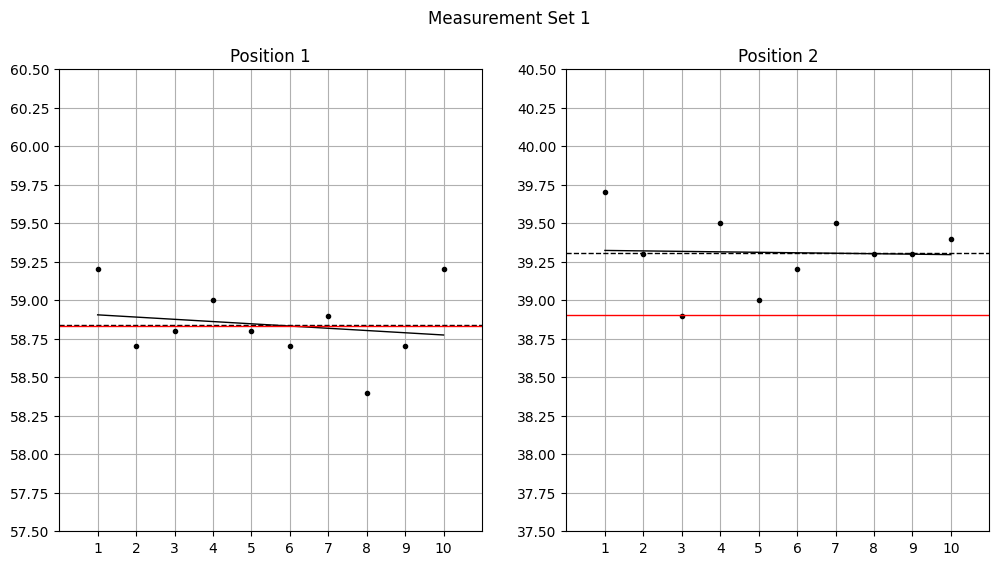

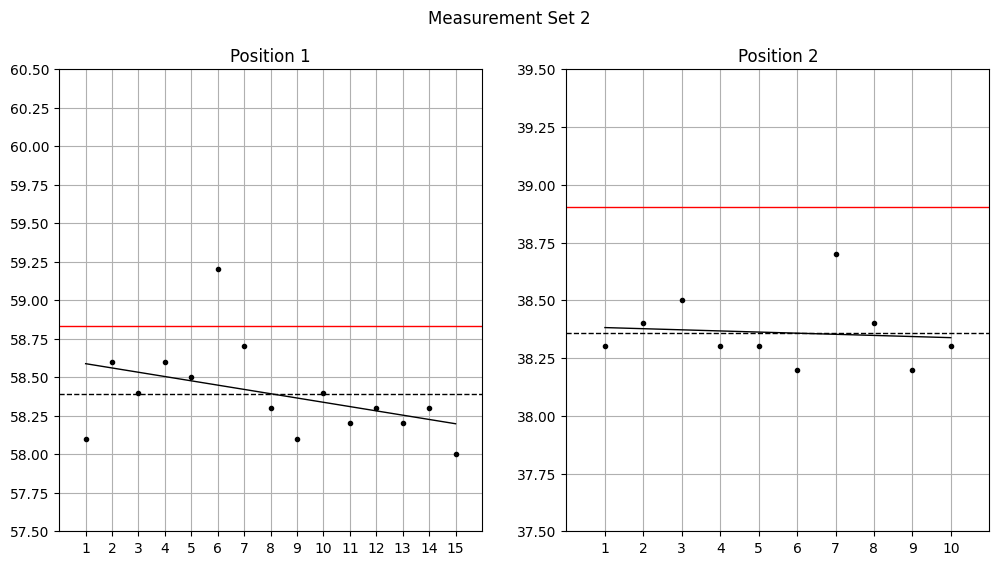

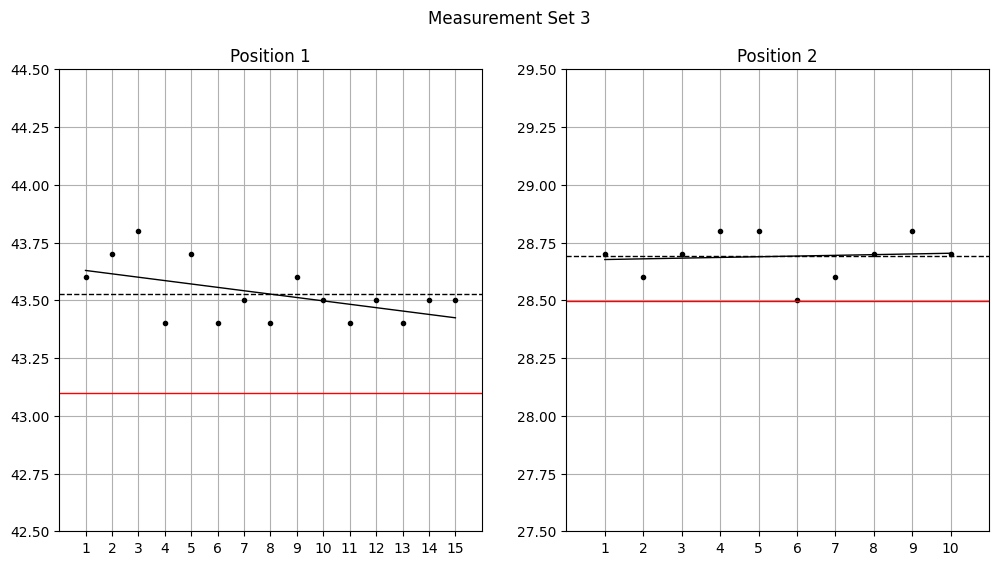

In [37]:
# Linear Function for use in Curve Fit
def linearFunc(x: float, a: float, b: float) -> float:
    return a * x + b

# Define Dataset Class
class dataSet:
    num: int
    p1: npt.NDArray[np.float64] = np.array([]) # Position 1
    p2: npt.NDArray[np.float64] = np.array([]) # Position 2

    p1_m: float # Mean [μV]
    p2_m: float # Mean [μV]
    p1_s: float # Standard Deviation
    p2_s: float # Standard Deviation

    # Output of Curve Fitting (Params)
    p1_popt: npt.NDArray[np.float64] = np.array([])
    p2_popt: npt.NDArray[np.float64] = np.array([])

    def __init__(self,
                 p1: npt.NDArray[np.float64],
                 p2: npt.NDArray[np.float64],
                 p1_m: float, p2_m: float,
                 p1_s: float, p2_s: float,
                 p1_popt: npt.NDArray[np.float64],
                 p2_popt: npt.NDArray[np.float64]):
        self.p1 = p1
        self.p2 = p2
        self.p1_m = p1_m
        self.p2_m = p2_m
        self.p1_s = p1_s
        self.p2_s = p2_s
        self.p1_popt = p1_popt
        self.p2_popt = p2_popt

    def plotSet(self) -> None:
        if self.num == 3 :
            p1_th = s3p1_th
            p2_th = s3p2_th
        else :
            p1_th = s12p1_th
            p2_th = s12p2_th

        plt.figure(num=self.num, figsize=[12,6])
        plt.suptitle("Measurement Set " + str(self.num))

        # Plot of Position 1
        xdata = range(1,np.size(self.p1)+1)
        plt.subplot(1,2,1)
        plt.title("Position 1")
        plt.plot(xdata, self.p1, 'k.')
        plt.plot([0,np.size(self.p1)+1],[self.p1_m, self.p1_m],
                 'k--',linewidth=1)
        plt.plot(xdata, linearFunc(xdata, *self.p1_popt),
                 'k',linewidth=1)
        plt.plot([0,np.size(self.p1)+1], [p1_th, p1_th],
                 'r',linewidth=1)

        plt.grid(True)
        plt.xlim([0,np.size(self.p1)+1])
        plt.xticks(range(1,np.size(self.p1)+1))
        plt_ymin: float = np.floor(np.min([np.min(self.p1), p1_th])) - 0.50
        plt_ymax: float = np.ceil(np.max([np.max(self.p1), p1_th])) + 0.50
        plt.ylim(plt_ymin, plt_ymax)
        plt.yticks(np.arange(plt_ymin,plt_ymax + 0.25,0.25))

        # Plot of Position 2
        xdata = range(1,np.size(self.p2)+1)
        plt.subplot(1,2,2)
        plt.title("Position 2")
        plt.plot(xdata, self.p2, 'k.')
        plt.plot([0,np.size(self.p2)+1],[self.p2_m, self.p2_m],
                 'k--',linewidth=1)
        plt.plot(xdata, linearFunc(xdata, *self.p2_popt),
                 'k',linewidth=1)
        plt.plot([0,np.size(self.p2)+1], [p2_th, p2_th],
                 'r',linewidth=1)
        
        plt.grid(True)
        plt.xlim([0,np.size(self.p2)+1])
        plt.xticks(range(1,np.size(self.p2)+1))
        plt_ymin: float = np.floor(np.min([np.min(self.p2), p2_th])) - 0.50
        plt_ymax: float = np.ceil(np.max([np.max(self.p2), p2_th])) + 0.50
        plt.ylim(plt_ymin, plt_ymax)
        plt.yticks(np.arange(plt_ymin,plt_ymax + 0.25,0.25))
        plt.show()

def parseSet(set_: npt.NDArray[np.float16]) -> dataSet:
    last_row: int = 0
    pos1: npt.NDArray[np.float16] = set_[range(last_row + 1, last_row + int(set_[last_row,2]) + 1),0:2]
    last_row = last_row + int(set_[last_row,2]) + 1
    pos2: npt.NDArray[np.float16] = set_[range(last_row + 1, last_row + int(set_[last_row,2]) + 1),0:2]

    pos1 = np.float64(pos1[:,0]) - np.float64(pos1[:,1])
    pos2 = np.float64(pos2[:,0]) - np.float64(pos2[:,1])

    p1_m: float = np.mean(pos1)
    p2_m: float = np.mean(pos2)
    p1_s: float = np.std(pos1)
    p2_s: float = np.std(pos2)

    p1_popt: list[float] = curve_fit(linearFunc, range(1,np.size(pos1)+1), pos1)[0]
    p2_popt: list[float] = curve_fit(linearFunc, range(1,np.size(pos2)+1), pos2)[0]

    return dataSet(pos1, pos2, p1_m, p2_m, p1_s, p2_s, p1_popt, p2_popt)

s1 = parseSet(set1)
s1.num = 1
s1.plotSet()

s2 = parseSet(set2)
s2.num = 2
s2.plotSet()

s3 = parseSet(set3)
s3.num = 3
s3.plotSet()